In [1]:
import torch

def pairwise_squared_dists(X):
    """Calculate the pairwise squared-distances among all points in X
    Calculates ||x_i - x_j||_2^2 for each pair of rows x_i and x_j
    
    Args:
        X : Data in (Npts x d) PyTorch tensor.
    """
    
    tmp = torch.mm(X,X.transpose(0,1));
    selfdots = torch.diag(tmp);
    
    res = (selfdots.reshape(-1,1)+selfdots) - tmp - tmp.transpose(0,1);
    return res;

def Pj_given_i_fixed_sigma2s(d2,s2,nu=float("Inf")):
    """Calculate p_{j|i} for specified values of sigma_i^2
    
    Args:
        X : Data in (Npts x d) PyTorch tensor.
        nu=Inf : Tail fatness of distribution used (Inf = Gaussian)
    """
    Npts = len(s2);
    
    if nu < float("Inf"):
        numerators = 1./ (1.+ (d2/s2.reshape(-1,1).repeat(1,N)/nu) )**((nu+1.)/2.)
        lognumerators = -(nu+1.)/2. * torch.log( 1.+ (d2/s2.reshape(-1,1).repeat(1,N)/nu) );
    else:
        lognumerators = -d2 / (2.*s2.reshape(-1,1).repeat(1,Npts));
        numerators = torch.exp( lognumerators );
    
    
    numerators = torch.triu(numerators,1) + torch.tril(numerators,-1); # Zero out diagonal entries
    
    tmp = torch.sum(numerators,dim=1,keepdim=True); # Calculate row sums
    
    Pjgiveni = numerators / tmp.repeat(1,Npts) # Turn each row into a conditional distribution
    
    logPjgiveni2 = lognumerators - torch.log(tmp).repeat(1,Npts);

    prods = Pjgiveni*logPjgiveni2;
    perp = 2.**(-1.*torch.sum(prods,dim=1)/ torch.log(torch.tensor(2.)));
    return Pjgiveni, perp;

def Pj_given_i(X,setPerp=200,s2_low=1e-4,s2_high=5e5,Niter=40,nu=float("Inf")):
    """Calculate p_{j|i} for a fixed perplexity value setPerp.
    Performs bisection method to find value of sigma_i for each data point
    so that p_{j|i} has specified perplexity value.
    
    Args:
        X : Data in (Npts x d) PyTorch tensor.
        setPerp=200 : User-specified perplexity
        nu=Inf : Tail fatness of distribution used (Inf = Gaussian)
        
        Niter : number of iterations of bisection method to perform
        s2_low : low value of sigma^2 to start bisection
        s2_high : high value of sigma^2 to start bisection
    """
    Npts = X.size()[0];

    d2 = pairwise_squared_dists(X);

    s2_low = torch.ones(Npts)*s2_low;
    s2_high = torch.ones(Npts)*s2_high;
    
    _,perps_low = Pj_given_i_fixed_sigma2s(d2,s2_low,nu=nu);
    _,perps_high = Pj_given_i_fixed_sigma2s(d2,s2_high,nu=nu);
    
    notlowenough = perps_low > setPerp;    
    nothighenough = perps_high < setPerp;
    
    if torch.any(notlowenough):
        print('WARNING: sigma_low not low enough')
    if torch.any(nothighenough):
        print('WARNING: sigma_high not high enough')

    for nn in range(Niter):
        s2_mid = (s2_low + s2_high)*.5;
        Pjgiveni,perps_mid = Pj_given_i_fixed_sigma2s(d2,s2_mid,nu);
        

        gobig = perps_mid > setPerp;
        #gobig = torch.tensor(gobig);
        gobig = gobig.clone();
        s2_low[~gobig] = s2_mid[~gobig];
        s2_high[gobig] = s2_mid[gobig];

    return Pjgiveni, s2_mid, perps_mid;


def tsne(p,target_dim=2,eta=200.,Niter=100,s2=None,Y0=None,nu=1.,variant='original'):
    """Perform t-SNE to obtain data embeddings representing the origin distribution p
    
    Args:
        p : similarity distribution of original data
        target_dim=2 : dimension of target space to embed data into
        nu=1 : tail fatness to use in computation of target similarities
        variant='original' : variant of t-SNE to perform: original, original_s2, conditional, conditional_s2
        s2=None : sigma_i^2 values to use when computing a variant of the t-SNE algorithm that uses these values
        Y0=None : initial condition to use for data embedding. If not specified, is set randomly
        
        eta=200 : learning rate or step size for gradient descent
        Niter=100 : number of iterations to perform
    """
    
    nu = float(nu);
    eta = float(eta);
    N = p.size()[0];
    
    if Y0 is None:
        Y = torch.randn(N,target_dim)*1e-6;
    else:
        Y = Y0;
        
    if s2 is None:
        s2 = torch.ones(N);
        
    Y = Y.clone().detach().requires_grad_(True);

    Cs = torch.zeros(Niter);

    for nn in range(Niter):
        d2 = pairwise_squared_dists(Y);
        
        
        if variant == 'conditional_s2':
            numers = 1./ (1.+ (d2/s2.reshape(-1,1).repeat(1,N)/nu) )**((nu+1.)/2.)
            numers = torch.tril(numers,-1) + torch.triu(numers,1);
            rowsums = torch.sum(numers,dim=1);
            qjgiveni = numers / rowsums.reshape(-1,1).repeat(1,N);
            q = (qjgiveni + qjgiveni.transpose(0,1))/(2*N);
        elif variant == 'conditional':
            numers = 1./ (1.+ (d2/nu) )**((nu+1.)/2.)
            numers = torch.tril(numers,-1) + torch.triu(numers,1);
            rowsums = torch.sum(numers,dim=1);
            qjgiveni = numers / rowsums.reshape(-1,1).repeat(1,N);
            q = (qjgiveni + qjgiveni.transpose(0,1))/(2*N);
        elif variant == 'original_s2':
            numers = 1./ (1.+ (d2/s2.reshape(-1,1).repeat(1,N)/nu) )**((nu+1.)/2.)
            numers = torch.tril(numers,-1) + torch.triu(numers,1);
            totalmass = torch.sum(numers);
            q = numers / totalmass;
            q = (q + q.transpose(0,1))/2.;
        elif variant == 'original':
            numers = 1./ (1.+ (d2/nu) )**((nu+1.)/2.)
            numers = torch.tril(numers,-1) + torch.triu(numers,1);
            totalmass = torch.sum(numers);
            q = numers / totalmass;
        
        q = q + torch.eye(N); # avoid problems with autograd and nan

        tmp1 = p*torch.log(p);
        tmp1[p==0] = 0;

        tmp2 = p*torch.log(q);
        tmp2[q==0] = 0;
        tmp = tmp1 - tmp2;
        tmp = torch.triu(tmp,1) + torch.tril(tmp,-1);
        C = torch.sum(tmp);
        Cs[nn] = C.detach();

        C.backward();
        Ygrad = Y.grad;

        Y = Y - eta*Ygrad;
        #Y = torch.tensor(Y.detach(),requires_grad=True)
        Y = Y.clone().detach().requires_grad_(True);
    return Y,Cs

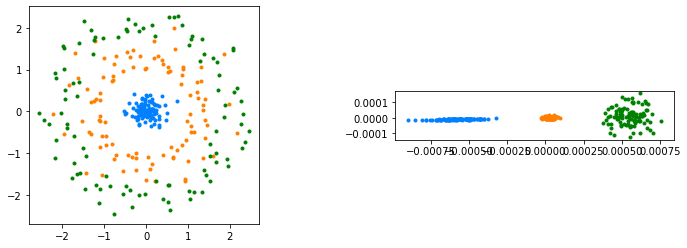

In [12]:
import numpy as np
import matplotlib.pyplot as plt

Nincloud = 100;
origin_dim = 50;

torch.manual_seed(2020)

X = torch.zeros(0,origin_dim);
sds = [1., 50.];
sds = [1., 5., 25.];

for jj,sd in enumerate(sds):
    Xtmp = sd*torch.randn(Nincloud,origin_dim);
    X = torch.cat( (X,Xtmp), dim=0)
    
N = X.size()[0];

Pjgiveni,s2,perps = Pj_given_i(X,setPerp=80.,Niter=40,s2_high=1e6,nu=float("Inf"));
p = (Pjgiveni + Pjgiveni.transpose(0,1)) / (2*N);

Y_orig,Cs   = tsne(p,target_dim=2,Niter=100,variant='original');
Y_conds2,Cs = tsne(p,target_dim=2,Niter=100,variant='conditional_s2', s2=s2);

Ys = [Y_orig, Y_conds2];

mycs = [(0,.5,1), (1,.5,0), (0,.5,0)];

plt.figure(figsize=(12,4));

for ii,Y in enumerate(Ys):
    plt.subplot(1,2,1+ii);
    Yplot = Y.detach().numpy();
    for jj in range(len(sds)):
        res = np.arange(jj*Nincloud, (jj+1)*Nincloud);
        plt.plot(Yplot[res,0],Yplot[res,1],'.',color=mycs[jj]);
    plt.gca().set_aspect(1)

plt.gcf().subplots_adjust(wspace=.4)
#plt.savefig('example_output.eps',bbox_inches='tight')